
<div style="text-align: center; line-height: 0; padding-top: 9px;">  
  <img src="/Volumes/cmidev/default/preventech/DBX_hack/compnovai_logo.PNG" alt="Image">  
</div> 

In this approach, embeddings calculated for selected features (Fault Code, Engine Name, Fail Code and Claim Narrative) are concatenated and a training data set is prepared. After this concatenation, each example in the training dataset is an array of 4096 floats as there are 1024 embeddings per feature. 

Label is taking as FAILURE_MODE_BUCKET text and is encoded.

Each training example is converted into a matrix of 64 *64 to treat it as an image having pixles converted into floats.

We tried 2 model architectures:<br>
**Deep Neural Network:**
A fully connected neural network model is built by stacking these images together in training data and model is fit on train/test and evaluated for accuracy since it is a multi-class classification use case. 

**Multi-Class Classification Model:**
We used the One Vs Rest Classifier to predict class label by performing grid-search on hyper parameters to come up with the best model. 

During this, currenty classes having single training example are added back to the training dataset by repeating examples (oversampling) from this dataset as stratificaion needs at least 2 examples per class. SMOTE/Class balancing is performed after manual oversampling. 

Model is trained and predicted on validation dataset by applying similar preprocessing techniques.

Take only row 3,4,5,8 (FC, ENgine Name, FailCode, Claim Narrative) features' embeddings

In [0]:
import pandas as pd
import numpy as np

In [0]:
### Run below code if GPU enabled cluster experiences memory issues
# from numba import cuda

# # This will reset the GPU memory, clearing all allocated memory.
# cuda.select_device(0)  # Selects the first GPU by default
# cuda.close()

# Load embeddings of selected features and concatenate those into an array

In [0]:
import pandas as pd  
import numpy as np  
  
def load_embeddings_chunks(claim_id):  
    # Load the relevant rows from the Spark SQL table  
    query = "select embedding from cmidev.cbu_ccims_poc.claim_text_embeddings where CLAIM_ID_SEQ = " + str(claim_id)  
    embeddings_df = spark.sql(query).toPandas()  
  
    # Extract the desired elements from the embeddings arrays  
    embeddings_chunks = np.concatenate(embeddings_df['embedding'].iloc[[3, 4, 5, 8]].values)  
  
    return embeddings_chunks.tolist()  


# Create training dataset

In [0]:
import pandas as pd
from pyspark.sql import functions as F
df = pd.DataFrame()
def CreateDataset(limit):
  # query = "select CLAIM_ID_SEQ,DOCUMENT, FAILURE_MODE_BUCKET  from cmidev.cbu_ccims_poc.ccims_claim_inspection_feature where FAILURE_MODE_BUCKET !='Not Inspected' limit  "+str(limit)+""  

  query = """
  SELECT CLAIM_ID_SEQ, DOCUMENT, FAILURE_MODE_BUCKET
  FROM (
    SELECT CLAIM_ID_SEQ, DOCUMENT, FAILURE_MODE_BUCKET,
           ROW_NUMBER() OVER (PARTITION BY FAILURE_MODE_BUCKET ORDER BY CLAIM_ID_SEQ) as row_num
    FROM cmidev.cbu_ccims_poc.ccims_claim_inspection_feature
    WHERE FAILURE_MODE_BUCKET != 'Not Inspected'
  ) tmp
  WHERE row_num >= 5
  LIMIT """ + str(limit)

  # print(query)


  claims = spark.sql(query).toPandas()
  df = pd.DataFrame()
  chunks=[]
  for claim_id in claims['CLAIM_ID_SEQ'].tolist():
      embeddings_chunks = []
      embeddings_chunks = (load_embeddings_chunks(claim_id=claim_id))
      chunks.append(embeddings_chunks)
  df['claim_id'] = claims['CLAIM_ID_SEQ'].tolist()
  df['embeddings'] = chunks#str(embeddings_chunks)
  df['document'] = claims['DOCUMENT'].tolist()
  df['label'] = claims['FAILURE_MODE_BUCKET'].tolist()
  return df

# Display the DataFrame
df = CreateDataset(limit=24000)
# display(df)

In [0]:
df.groupby('label').count()

claim_id  embeddings  document
label                                                                     
ACT(E) BROKEN SOLDER JOINT                      1171        1171      1171
ACT(E) CBA COMPONENT/PROCESS DEFECT              188         188       188
ACT(E) CONTAMINATION OF CRYSTAL                    7           7         7
ACT(E) COOLING BODY POROSITY                       6           6         6
ACT(E) CORRODED MOUNTING BOLT                      2           2         2
ACT(E) CORROSION OF HOUSING AT CONNECTOR         907         907       907
ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)      2244        2244      2244
ACT(E) DAMAGED CONNECTOR SEAL                     10          10        10
ACT(E) GEAR TRAIN WEAR                            71          71        71
ACT(E) MICROPROCESSOR ISSUE                       42          42        42
ACT(E) NON-HOLSET PARTS                            4           4         4
ACT(E) OUTPUT GEAR AXIAL PLAY                      3           3         3
ACT(E) SUPPLIER ANALYSIS NOT CONDUCTED           235         235       235
ACT(E) SUPPLIER MANUFACTURING FAULT              709         709       709
ACT(E) UNKNOWN/INDETERMINATE                      16          16        16
ACT(E) WAITING SUPPLIER ANALYSIS                 583         583       583
ACT(E) WATER CONTAMINATION (788)                   5           5         5
ACT(E) WRONG PART RETURNED                       179         179       179
ADJUSTED/DAMAGED BY CUSTOMER                     142         142       142
COMP HSG CRACKED/BROKEN                           11          11        11
CONSEQUENTIAL DAMAGE                            3369        3369      3369
CUMMINS MANUFACTURING FAULT                      136         136       136
IMPELLER WHEEL FOD                               144         144       144
NOZZLE RING ASSY RIVET(S) BROKEN/WORN            827         827       827
NOZZLE SEAL RING BINDING/SEIZED (INNER)            2           2         2
OIL CONTAMINATION                                 92          92        92
OIL DELAY/STARVATION                             176         176       176
PENDING GROUP REVIEW                               9           9         9
PENDING LAB RESPONSE                               1           1         1
SHROUD PLATE LOOSE/DETACHED                       17          17        17
SUPPLIER MANUFACTURING FAULT                      67          67        67
THRUST BEARING WORN                              168         168       168
TROUBLE NOT FOUND                               2552        2552      2552
TSS - BODY CRACKED/BROKEN                        508         508       508
TSS - BODY POROSITY                              114         114       114
TSS - CABLE FRETTING                             505         505       505
TSS - CONTAMINATION OF COIL                       14          14        14
TSS - CORROSION IN SENSOR BODY                  1976        1976      1976
TSS - OVERSTRESSED SKEIN WIRE                     34          34        34
TSS - TROUBLE NOT FOUND                         1705        1705      1705
TSS - UNKNOWN/INDETERMINATE                        3           3         3
TSS - WELD PROCESS DEFECT                       2748        2748      2748
TSS - WRONG PART RETURNED                         95          95        95
TURBINE HSG CRACKED/BROKEN                        64          64        64
TURBINE HSG RUSTY/CORRODED                         1           1         1
TURBINE WHEEL HCF                                105         105       105
TURBINE/NOZZLE FOD                              1845        1845      1845
WRONG PART RETURNED                              188         188       188

# Identify singleton classes (Classes having single example in df) and oversample them

In [0]:
import pandas as pd
# df = pd.read_csv("/Volumes/cmidev/default/preventech/DBX_hack/20k_embeddings_training_data.csv")


# Remove unwanted class labels (as per SME recommendation)

In [0]:
def RemoveUnwantedLabelExamples(df):
  unwanted_failmode_buckets = ['ACT(E) PENDING SUPPLIER ANALYSIS',
                               'TSS - PENDING SUPPLIER ANALYSIS',
                               'ACT(E) SUPPLIER ANALYSIS NOT CONDUCTED',
                               'UNKNOWN/INDETERMINATE',
                               'ACT(E) WRONG PART RETURNED',
                               'WRONG PART RETURNED',
                               'TSS - SUPPLIER ANALYSIS NOT CONDUCTED'
                               'TSS - WRONG PART RETURNED',
                               'ACT(E) UNKNOWN/INDETERMINATE',
                               'PENDING GROUP REVIEW',
                               'PENDING LAB RESPONSE',
                               'WRONG PART USED',
                               'ACT(E) WRONG PART USED',
                               'TSS - UNKNOWN/INDETERMINATE',
                               'TSS - WRONG PART USED',
                               'OUT OF WARRANTY']
  df_clean = df[~df['label'].isin(unwanted_failmode_buckets)]
  return df_clean


In [0]:
df = RemoveUnwantedLabelExamples(df)

In [0]:

(df.groupby('label').count())

claim_id  embeddings  document
label                                                                     
ACT(E) BROKEN SOLDER JOINT                      1171        1171      1171
ACT(E) CBA COMPONENT/PROCESS DEFECT              188         188       188
ACT(E) CONTAMINATION OF CRYSTAL                    7           7         7
ACT(E) COOLING BODY POROSITY                       6           6         6
ACT(E) CORRODED MOUNTING BOLT                      2           2         2
ACT(E) CORROSION OF HOUSING AT CONNECTOR         907         907       907
ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)      2244        2244      2244
ACT(E) DAMAGED CONNECTOR SEAL                     10          10        10
ACT(E) GEAR TRAIN WEAR                            71          71        71
ACT(E) MICROPROCESSOR ISSUE                       42          42        42
ACT(E) NON-HOLSET PARTS                            4           4         4
ACT(E) OUTPUT GEAR AXIAL PLAY                      3           3         3
ACT(E) SUPPLIER MANUFACTURING FAULT              709         709       709
ACT(E) WAITING SUPPLIER ANALYSIS                 583         583       583
ACT(E) WATER CONTAMINATION (788)                   5           5         5
ADJUSTED/DAMAGED BY CUSTOMER                     142         142       142
COMP HSG CRACKED/BROKEN                           11          11        11
CONSEQUENTIAL DAMAGE                            3369        3369      3369
CUMMINS MANUFACTURING FAULT                      136         136       136
IMPELLER WHEEL FOD                               144         144       144
NOZZLE RING ASSY RIVET(S) BROKEN/WORN            827         827       827
NOZZLE SEAL RING BINDING/SEIZED (INNER)            2           2         2
OIL CONTAMINATION                                 92          92        92
OIL DELAY/STARVATION                             176         176       176
SHROUD PLATE LOOSE/DETACHED                       17          17        17
SUPPLIER MANUFACTURING FAULT                      67          67        67
THRUST BEARING WORN                              168         168       168
TROUBLE NOT FOUND                               2552        2552      2552
TSS - BODY CRACKED/BROKEN                        508         508       508
TSS - BODY POROSITY                              114         114       114
TSS - CABLE FRETTING                             505         505       505
TSS - CONTAMINATION OF COIL                       14          14        14
TSS - CORROSION IN SENSOR BODY                  1976        1976      1976
TSS - OVERSTRESSED SKEIN WIRE                     34          34        34
TSS - TROUBLE NOT FOUND                         1705        1705      1705
TSS - WELD PROCESS DEFECT                       2748        2748      2748
TSS - WRONG PART RETURNED                         95          95        95
TURBINE HSG CRACKED/BROKEN                        64          64        64
TURBINE HSG RUSTY/CORRODED                         1           1         1
TURBINE WHEEL HCF                                105         105       105
TURBINE/NOZZLE FOD                              1845        1845      1845

In [0]:
len(df)

23369

In [0]:
#Remaining useful labels
len(np.unique(df['label'].tolist()))

41

# Write concatenated embeddings based training data into csv for later use

In [0]:

#Write data to csv
# df.to_csv("/Volumes/cmidev/default/preventech/DBX_hack/24k_embeddings_training_data.csv") #Dataset with 5 samples of each class
df.to_csv("/Volumes/cmidev/default/preventech/DBX_hack/24k_embeddings_training_data_v1.csv") #Dataset with all samples of each class

# Read training data

In [0]:
df = pd.read_csv("/Volumes/cmidev/default/preventech/DBX_hack/24k_embeddings_training_data_v1.csv")

In [0]:
(df.groupby('label').count())

Unnamed: 0  ...  document
label                                                   ...          
ACT(E) BROKEN SOLDER JOINT                        1171  ...      1171
ACT(E) CBA COMPONENT/PROCESS DEFECT                188  ...       188
ACT(E) CONTAMINATION OF CRYSTAL                      7  ...         7
ACT(E) COOLING BODY POROSITY                         6  ...         6
ACT(E) CORRODED MOUNTING BOLT                        2  ...         2
ACT(E) CORROSION OF HOUSING AT CONNECTOR           907  ...       907
ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)        2244  ...      2244
ACT(E) DAMAGED CONNECTOR SEAL                       10  ...        10
ACT(E) GEAR TRAIN WEAR                              71  ...        71
ACT(E) MICROPROCESSOR ISSUE                         42  ...        42
ACT(E) NON-HOLSET PARTS                              4  ...         4
ACT(E) OUTPUT GEAR AXIAL PLAY                        3  ...         3
ACT(E) SUPPLIER MANUFACTURING FAULT                709  ...       709
ACT(E) WAITING SUPPLIER ANALYSIS                   583  ...       583
ACT(E) WATER CONTAMINATION (788)                     5  ...         5
ADJUSTED/DAMAGED BY CUSTOMER                       142  ...       142
COMP HSG CRACKED/BROKEN                             11  ...        11
CONSEQUENTIAL DAMAGE                              3369  ...      3369
CUMMINS MANUFACTURING FAULT                        136  ...       136
IMPELLER WHEEL FOD                                 144  ...       144
NOZZLE RING ASSY RIVET(S) BROKEN/WORN              827  ...       827
NOZZLE SEAL RING BINDING/SEIZED (INNER)              2  ...         2
OIL CONTAMINATION                                   92  ...        92
OIL DELAY/STARVATION                               176  ...       176
SHROUD PLATE LOOSE/DETACHED                         17  ...        17
SUPPLIER MANUFACTURING FAULT                        67  ...        67
THRUST BEARING WORN                                168  ...       168
TROUBLE NOT FOUND                                 2552  ...      2552
TSS - BODY CRACKED/BROKEN                          508  ...       508
TSS - BODY POROSITY                                114  ...       114
TSS - CABLE FRETTING                               505  ...       505
TSS - CONTAMINATION OF COIL                         14  ...        14
TSS - CORROSION IN SENSOR BODY                    1976  ...      1976
TSS - OVERSTRESSED SKEIN WIRE                       34  ...        34
TSS - TROUBLE NOT FOUND                           1705  ...      1705
TSS - WELD PROCESS DEFECT                         2748  ...      2748
TSS - WRONG PART RETURNED                           95  ...        95
TURBINE HSG CRACKED/BROKEN                          64  ...        64
TURBINE HSG RUSTY/CORRODED                           1  ...         1
TURBINE WHEEL HCF                                  105  ...       105
TURBINE/NOZZLE FOD                                1845  ...      1845

[41 rows x 4 columns]

In [0]:
# import pandas as pd  
# from imblearn.over_sampling import RandomOverSampler ,SMOTE 
  
  
# # Get the embeddings and labels  
# embeddings = df['embeddings'].tolist()  
# labels = df['label'].tolist()  
  
# # Compute the class counts    
# class_counts = pd.Series(labels).value_counts()    
    
# # Find the singleton classes    
# singleton_classes = class_counts[class_counts <= 4].index    
# print(singleton_classes)
# # Filter the dataframe to remove samples with singleton classes    
# mask = ~pd.Series(labels).isin(singleton_classes)    
# df_filtered = df[mask]  
  
# # Perform oversampling on the singleton classes  
# mask = pd.Series(labels).isin(singleton_classes)    
# df_filtered_single = df[mask]  
# # display(df_filtered_single)
# X = (df_filtered_single['embeddings'].tolist())
# Y = (df_filtered_single['label'].tolist())
 
# oversampler = RandomOverSampler()  

# # Repeat the singleton class examples  
# df_repeated = pd.concat([df[df['label'] == c].sample((class_counts.max()+2), replace=True, random_state=42) for c in singleton_classes])  
  
 
# # display( pd.DataFrame({'embeddings': X_resampled, 'label': y_resampled}))
# # display(df_repeated)
  
# # Combine the resampled data with the filtered data  
# # df_resampled = pd.concat([df_filtered, pd.DataFrame({'embeddings': X_resampled, 'label': y_resampled})], ignore_index=True,axis=0)  
# df =  pd.concat([df_filtered,df_repeated],ignore_index=True, axis=0)

In [0]:
import pandas as pd  
from imblearn.over_sampling import RandomOverSampler ,SMOTE 

# Compute the class counts    
class_counts = df['label'].value_counts()    

# Find the singleton classes    
singleton_classes = class_counts[class_counts <= 10].index    
print(singleton_classes)

# Filter the dataframe to remove samples with singleton classes    
mask = ~df['label'].isin(singleton_classes)    
df_filtered = df[mask]  

# Perform oversampling on the singleton classes  
mask = df['label'].isin(singleton_classes)    
df_filtered_single = df[mask]  

# Assuming the rest of your code works as intended, but ensure you use DataFrame operations directly
oversampler = RandomOverSampler()  

# Repeat the singleton class examples  
df_repeated = pd.concat([df[df['label'] == c].sample((class_counts.max()+2), replace=True, random_state=42) for c in singleton_classes])  

# Combine the resampled data with the filtered data  
df = pd.concat([df_filtered, df_repeated], ignore_index=True, axis=0)

Index([], dtype='object')


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-4149922708429131>, line 23
     20 oversampler = RandomOverSampler()  
     22 # Repeat the singleton class examples  
---> 23 df_repeated = pd.concat([df[df['label'] == c].sample((class_counts.max()+2), replace=True, random_state=42) for c in singleton_classes])  
     25 # Combine the resampled data with the filtered data  
     26 df = pd.concat([df_filtered, df_repeated], ignore_index=True, axis=0)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len(args) > num_allow_args:
    326     warnings.warn(
    327         msg.format(arguments=_format_argument_list(allow_args)),
    328         FutureWarning,
    329         stacklevel=find_stack_level(),
    330     )
--> 331 return func(*args

In [0]:
df.groupby('label').count()

Unnamed: 0  ...  document
label                                                   ...          
ACT(E) BROKEN SOLDER JOINT                        1171  ...      1171
ACT(E) CBA COMPONENT/PROCESS DEFECT                188  ...       188
ACT(E) CONTAMINATION OF CRYSTAL                   3371  ...      3371
ACT(E) COOLING BODY POROSITY                      3371  ...      3371
ACT(E) CORRODED MOUNTING BOLT                     3371  ...      3371
ACT(E) CORROSION OF HOUSING AT CONNECTOR           907  ...       907
ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)        2244  ...      2244
ACT(E) DAMAGED CONNECTOR SEAL                     3371  ...      3371
ACT(E) GEAR TRAIN WEAR                              71  ...        71
ACT(E) MICROPROCESSOR ISSUE                         42  ...        42
ACT(E) NON-HOLSET PARTS                           3371  ...      3371
ACT(E) OUTPUT GEAR AXIAL PLAY                     3371  ...      3371
ACT(E) SUPPLIER MANUFACTURING FAULT                709  ...       709
ACT(E) WAITING SUPPLIER ANALYSIS                   583  ...       583
ACT(E) WATER CONTAMINATION (788)                  3371  ...      3371
ADJUSTED/DAMAGED BY CUSTOMER                       142  ...       142
COMP HSG CRACKED/BROKEN                             11  ...        11
CONSEQUENTIAL DAMAGE                              3369  ...      3369
CUMMINS MANUFACTURING FAULT                        136  ...       136
IMPELLER WHEEL FOD                                 144  ...       144
NOZZLE RING ASSY RIVET(S) BROKEN/WORN              827  ...       827
NOZZLE SEAL RING BINDING/SEIZED (INNER)           3371  ...      3371
OIL CONTAMINATION                                   92  ...        92
OIL DELAY/STARVATION                               176  ...       176
SHROUD PLATE LOOSE/DETACHED                         17  ...        17
SUPPLIER MANUFACTURING FAULT                        67  ...        67
THRUST BEARING WORN                                168  ...       168
TROUBLE NOT FOUND                                 2552  ...      2552
TSS - BODY CRACKED/BROKEN                          508  ...       508
TSS - BODY POROSITY                                114  ...       114
TSS - CABLE FRETTING                               505  ...       505
TSS - CONTAMINATION OF COIL                         14  ...        14
TSS - CORROSION IN SENSOR BODY                    1976  ...      1976
TSS - OVERSTRESSED SKEIN WIRE                       34  ...        34
TSS - TROUBLE NOT FOUND                           1705  ...      1705
TSS - WELD PROCESS DEFECT                         2748  ...      2748
TSS - WRONG PART RETURNED                           95  ...        95
TURBINE HSG CRACKED/BROKEN                          64  ...        64
TURBINE HSG RUSTY/CORRODED                        3371  ...      3371
TURBINE WHEEL HCF                                  105  ...       105
TURBINE/NOZZLE FOD                                1845  ...      1845

[41 rows x 4 columns]

In [0]:
# df.to_csv("/Volumes/cmidev/default/preventech/DBX_hack/20k_embeddings_training_data.csv", index=False)
df.to_csv("/Volumes/cmidev/default/preventech/DBX_hack/24k_embeddings_training_data.csv", index=False)

In [0]:
df['embeddings'] = df['embeddings'].apply(lambda x: [float(i) for i in x.strip('[]').split(',')])

In [0]:
df.describe()

Unnamed: 0      claim_id
count  53668.000000  5.366800e+04
mean   11813.269826  2.252823e+07
std     6667.725359  4.800443e+06
min       16.000000  1.537087e+07
25%     6700.750000  1.984586e+07
50%    11471.000000  2.347547e+07
75%    17321.250000  2.465726e+07
max    23999.000000  7.369448e+07

In [0]:
def smot_train_data(X,y):
  from imblearn.over_sampling import SMOTE

  # example of oversampling a multi-class classification dataset
  from collections import Counter
  from matplotlib import pyplot
  from sklearn.preprocessing import LabelEncoder
  # transform the dataset
  oversample = SMOTE(random_state=42)
  X_, y_ = oversample.fit_resample(X,y)
  # summarize distribution
  counter = Counter(y_)
  for k,v in counter.items():
    per = v / len(y_) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  # plot the distribution
  pyplot.bar(counter.keys(), counter.values())
  pyplot.show()
  return X_, y_

In [0]:
# from sklearn.model_selection import train_test_split
# # embeddings = df_filtered['embeddings'].tolist()
# # labels = df_filtered['label'].tolist()
# embeddings = df['embeddings'].tolist()
# labels = df['label'].tolist()
# X_train, X_test, y_train, y_test = train_test_split(
#     embeddings,
#     labels, 
#     test_size=0.3, 
#     random_state=42,
#     shuffle=True,
#     stratify=labels
# )

# Perform label encoding

In [0]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch

# Assuming y_train and y_test are pandas Series or lists of string labels
embeddings = df['embeddings'].tolist()
labels = df['label'].tolist()
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform y_train and y_test to integer labels
y_encoded = label_encoder.fit_transform(labels)

# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)



In [0]:
num_classes = len(np.unique(y_encoded))

# Pad shorter embeddings array with 0

In [0]:
X_rs = []
X_arr = np.array(embeddings)
for i in X_arr:
  if len(i) == 4096:
    X_rs.append(np.reshape(i, (64, 64)))
  else:
    #pad it with 0
    # print(len(i))
    padded = np.pad(i, (0, 4096 - len(i)), 'constant')  
    X_rs.append(np.reshape(padded, (64, 64)))



/root/.ipykernel/2071/command-4149922708429134-1521168996:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_arr = np.array(embeddings)


# Balance dataset using SMOTE

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer  

X_rs = np.array(X_rs)  
X_rs = X_rs.reshape(X_rs.shape[0], -1)  
  
# Create an instance of SimpleImputer  
imputer = SimpleImputer(strategy='constant', fill_value=0)  
  
# Apply the imputer to X_train_rs  
X_rs_imputed = imputer.fit_transform(X_rs)  
  
# Reshape X_train_rs_imputed to (samples, dim1, dim2)  
X_rs_imputed = X_rs_imputed.reshape(X_rs_imputed.shape[0], 64, 64)  
# Reshape X_train to (samples, dim1*dim2)  
X_flattened = X_rs_imputed.reshape(X_rs_imputed.shape[0], -1)  
# print(X_train_resampled.shape)

# Instantiate SMOTE  
smote = SMOTE(k_neighbors=3)  
  
# Apply SMOTE to X_train_flattened and y_train  
X_train_resampled, y_train_resampled = smote.fit_resample(X_flattened, y_encoded)  




Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ea8021630>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ea8aa4a60>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d68cef520>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d68ceff40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3ea6f70ee0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d68cfc160>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
2024-10-21 12:45:08.988547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d2d74c4c0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d2c31c040>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d2c31c1f0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00b91870>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00b91090>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d177cec20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d177cec20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d177cec20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d177cec20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00b91b40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d007cfac0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d003220e0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d177cec20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d007cf9a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00b909d0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00323010>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d177cec20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00323d90>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00385480>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d003bff40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00b13d00>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d60ee8940>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d00bc80d0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d608820e0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d685f8940>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3d685f8940>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


# Perform train-test split

In [0]:
from sklearn.model_selection import train_test_split
# embeddings = df_filtered['embeddings'].tolist()
# labels = df_filtered['label'].tolist()
embeddings = X_train_resampled.tolist()
labels = y_train_resampled.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    labels, 
    test_size=0.3, 
    random_state=42,
    shuffle=True,
    stratify=labels
)

In [0]:
X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)
# type(X_train_arr)

In [0]:
# len(np.unique(y_train_encoded))
train_labels = (np.unique(y_train)).tolist()

In [0]:
X_train_rs = []
for i in X_train_arr:
  if len(i) == 4096:
    X_train_rs.append(np.reshape(i, (64, 64)))
  else:
    #pad it with 0
    # print(len(i))
    padded = np.pad(i, (0, 4096 - len(i)), 'constant')  
    X_train_rs.append(np.reshape(padded, (64, 64)))



In [0]:
X_test_rs = []
for i in X_test_arr:
  if len(i) == 4096:
    X_test_rs.append(np.reshape(i, (64, 64)))
  else:
    #pad it with 0
    padded = np.pad(i, (0, 4096 - len(i)), 'constant')  
    X_test_rs.append(np.reshape(padded, (64, 64)))

In [0]:
# y_train_resampled_encoded = label_encoder.transform(y_train_resampled)
# len(y_train_resampled_encoded),len(X_train_resampled)

(53460, 53460)

Treat embeddings array as image by converting 4096 embeddings in each array of X train and test data into image tile of 64 by 64 matrix. Then build a simple sequential model on it to predict classes.

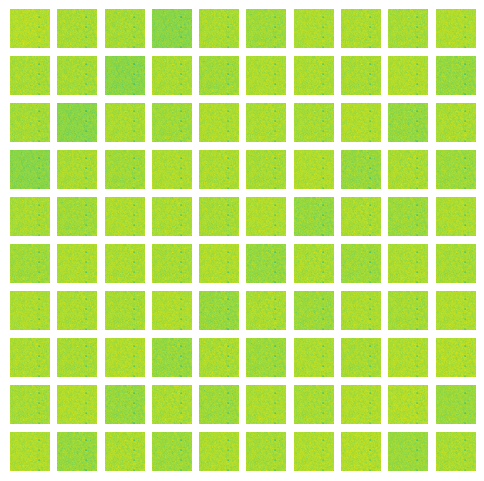

In [0]:
# plot all images in the dataset  
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))  
for i in range(10):  
    for j in range(10):  
        axs[i][j].imshow(X_train_rs[i * 1 + j],cmap='viridis')  
        axs[i][j].axis('off')  
  
plt.show() 

In [0]:
X_train_rs_stack = np.stack(X_train_rs)  
# X_test_rs_stack = np.stack(X_test_rs)  

# X_train_rs_stack = np.stack(X_train_resampled)  
X_test_rs_stack = np.stack(X_test_rs)  

# Check how many samples are created for each class after SMOTE balancing

In [0]:
from pyspark.sql.functions import col
# from pyspark.sql.types import StringType  # Import StringType

df_y_resampled = spark.createDataFrame(y_train_resampled).toDF("label")
display(df_y_resampled.groupBy("label").count())

label count 29 3371 39 3371 27 3371 37 3371 30 3371 0 3371 17 3371 36 3371 23 3371 19 3371 32 3371 35 3371 26 3371 6 3371 40 3371 3 3371 14 3371 10 3371 21 3371 38 3371 1 3371 8 3371 9 3371 13 3371 15 3371 16 3371 20 3371 22 3371 24 3371 25 3371 28 3371 31 3371 33 3371 34 3371 18 3371 12 3371 7 3371 5 3371 2 3371 11 3371 4 3371

Databricks visualization. Run in Databricks to view.

In [0]:
# from keras.utils import to_categorical  

# num_classes = len(label_encoder.classes_)  
# y_train_onehot = to_categorical(y_train_encoded, num_classes)  
# y_test_onehot = to_categorical(y_test_encoded, num_classes)  
# y_train_resampled_encoded_onehot = to_categorical(y_train_resampled_encoded, num_classes)  
# y_train_onehot = to_categorical(y_train, num_classes)  
# y_test_onehot = to_categorical(y_test, num_classes)  
# y_train_resampled_encoded_onehot = to_categorical(y_train_resampled_encoded, num_classes)  

In [0]:
num_classes

41

# Normalization of train and test data

In [0]:
# Compute the mean and standard deviation of the training data  
mean = np.mean(X_train_rs_stack, axis=0)  
std = np.std(X_train_rs_stack, axis=0)  
  
# Normalize the training and validation data  
X_train_norm = (X_train_rs_stack - mean) / std  
mean_test = np.mean(X_test_rs_stack, axis=0)  
std_test = np.std(X_test_rs_stack, axis=0) 
X_test_norm = (X_test_rs_stack - mean_test) / std_test  


In [0]:
print("Training Mean=",mean,"Std=",std,len(mean))
print("Testing Mean=",mean_test,"Std=",std_test)

Training Mean= [[-8.12206593e-02 -2.56173025e-01 -3.08194697e-01 ...  8.37094444e-01
  -4.67261415e-01 -2.83844058e-01]
 [ 2.80117650e-01 -9.42534357e-02 -6.07040507e-01 ...  4.83697710e-02
  -9.55517848e-02 -7.65874025e-02]
 [ 1.59335870e-01  6.07102788e-01  3.94466403e-02 ... -4.30915734e-01
   1.75241353e-02  5.06776575e-01]
 ...
 [-1.61823765e-01  7.70317372e-01  4.91063520e-01 ...  1.62215607e-01
   7.91533699e-01  6.40297373e-01]
 [-2.35376298e-01  4.64923139e-01 -6.41876726e-01 ... -3.94094352e-01
   5.06855710e-01 -1.32365466e+00]
 [ 7.84496747e-01 -1.86152238e-01  3.29693805e-01 ...  1.10647739e+00
  -5.40554430e-01  4.71813535e-04]] Std= [[0.34757951 0.31203209 0.54350144 ... 0.32997213 0.38539838 0.28316656]
 [0.40929397 0.360044   0.4228653  ... 0.28526773 0.31199556 0.3987816 ]
 [0.37114606 0.2791506  0.27050073 ... 0.25946171 0.43552249 0.30090604]
 ...
 [0.2917562  0.33084214 0.28948339 ... 0.42264485 0.42298719 0.36895338]
 [0.26575822 0.31410979 0.21055221 ... 0.351547

# Deep Learning NN Model

In [0]:
# from keras.models import Sequential    
# from keras.layers import Dense    
# import tensorflow as tf
    
  
    
# print(num_classes)


# # # create a single-layer neural network using Softmax activation function 
# # model_dnn = tf.keras.Sequential([  
# #     tf.keras.layers.Flatten(input_shape=(64, 64)),  
# #     tf.keras.layers.Dense(num_classes, activation='softmax')  
# # ]) 
# # # model_dnn = tf.keras.Sequential([  
# # #     tf.keras.layers.Flatten(input_shape=(64, 64)),  
# # #     tf.keras.layers.Dense(128, activation='relu'),  
# # #     tf.keras.layers.Dropout(0.5),  
# # #     tf.keras.layers.Dense(num_classes, activation='softmax')  
# # # ])  

# # model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
# from keras import regularizers  
# from keras.callbacks import EarlyStopping  
# # xavier_init = tf.keras.initializers.glorot_uniform()
# he_init = 'he_normal'

# model_dnn = tf.keras.Sequential([  
#     tf.keras.layers.Flatten(input_shape=(64, 64)),  
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001),kernel_initializer=he_init),  
#     # tf.keras.layers.Dropout(0.5),  

#     # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),kernel_initializer=he_init),  
#     # tf.keras.layers.Dropout(0.5),     
#     tf.keras.layers.Dense(num_classes, activation='softmax')  
# ])  
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  

# model_dnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])  
  
# # Define early stopping callback  
# early_stop = EarlyStopping(monitor='val_accuracy', patience=10)  

# # model.fit(X_train_rs, y_train_encoded, epochs=10, batch_size=32)  
# y_train_encoded_arr= np.array(y_train_encoded)
# y_test_encoded_arr= np.array(y_test_encoded)


# import mlflow
# with mlflow.start_run() as run:

#     history_dnn = model_dnn.fit(X_train_rs_stack, y_train_onehot, epochs=100, batch_size=32, validation_data=(X_test_rs_stack, y_test_onehot), callbacks=[early_stop])  

 


# Plot Deep NN Model performance

In [0]:
# import matplotlib.pyplot as plt
# plt.plot(history_dnn.history['val_accuracy'], label='Basic NN Test',color='red')
# plt.plot(history_dnn.history['accuracy'], label='Basic NN Train',color='green')

# plt.xlabel('Epoch')

# plt.ylabel('Accuracy')
# # plt.ylim(0,1.2)
# plt.grid('On')
# plt.legend()  
# plt.title("20k rows based model")
# plt.show() 

# Make predictions on test dataset using NN model

In [0]:

# # Make predictions on the new input tensor  
# predictions = model_dnn.predict(X_test_rs_stack)  
  
# # Get the predicted class labels  
# predicted_labels = np.argmax(predictions, axis=1)  
  
# # Convert the predicted class labels back to original label names  
# predicted_names = label_encoder.inverse_transform(predicted_labels)  
# # predicted_names

20K Train sample model

In [0]:
# num_classes = np.max(y_train) + 1  # Assuming class labels start from 0
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

In [0]:
# np.unique(y_test_onehot)

array([0., 1.], dtype=float32)

# Multiclass ML Model

In [0]:
from sklearn.svm import SVC  
from imblearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier  
import time

# estimators = [{'classifier': [OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=0))]}]

# pipe_dt = Pipeline([
#     ('clf', OneVsRestClassifier(estimator=RandomForestClassifier(random_state=0)))
# ])
estimators = [{'classifier': [OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=0))]}]

pipe_dt = Pipeline([
    ('clf', OneVsRestClassifier(estimator=RandomForestClassifier(
        n_estimators=200,  # Increased number of trees in the forest
        max_depth=20,      # Set maximum depth of the tree
        min_samples_split=5,  # Increased minimum number of samples required to split an internal node
        min_samples_leaf=2,   # Increased minimum number of samples required to be at a leaf node
        max_features='sqrt',  # Changed number of features to consider when looking for the best split
        random_state=0
    )))
])

# Now use X_train_flat for training
t0 = time.time()
pipe_dt.fit(X_train_flat, y_train)

print("done in %0.3fs" % (time.time() - t0))
# print("Best parameters found: ", grid_search.best_params_)

Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

done in 20024.987s


In [0]:
# from sklearn.model_selection import GridSearchCV
# import time

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'clf__estimator__n_estimators': [100, 200, 300],
#     'clf__estimator__max_depth': [10, 20, 30],
#     'clf__estimator__min_samples_split': [2, 5, 10],
#     'clf__estimator__min_samples_leaf': [1, 2, 4],
#     'clf__estimator__max_features': ['auto', 'sqrt', 'log2']
# }

# # Create the pipeline
# pipe_dt = Pipeline([
#     ('clf', OneVsRestClassifier(estimator=RandomForestClassifier(random_state=0)))
# ])

# X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)

# # Use GridSearchCV to find the best parameters
# grid_search = GridSearchCV(pipe_dt, param_grid, cv=5, n_jobs=-1, verbose=1)

# # Now use X_train_flat for training
# t0 = time.time()
# grid_search.fit(X_train_flat, y_train)

# print("done in %0.3fs" % (time.time() - t0))
# print("Best parameters found: ", grid_search.best_params_)
# from sklearn.metrics import accuracy_score
# X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

# # Train model with best parameters from grid search
# best_params = grid_search.best_params_
# pipe_dt.set_params(**best_params)
# pipe_dt.fit(X_train_flat, y_train)

# y_test_pred = pipe_dt.predict(X_test_flat)
# acc = accuracy_score(y_test, y_test_pred)
# display("Test accuracy:",acc)

# Evaluate test accuracy

In [0]:
from sklearn.metrics import accuracy_score
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

# Train model with best parameters from grid search
# best_params = grid_search.best_params_
# pipe_dt.set_params(**best_params)
# pipe_dt.fit(X_train_flat, y_train)

y_test_pred = pipe_dt.predict(X_test_flat)
acc = accuracy_score(y_test, y_test_pred)
display("Test accuracy:",acc)

'Test accuracy:'

0.930614508971638

In [0]:
import pandas as pd
import mlflow
# logged_model = 'runs:/92a1bd00d370418eab4658f341f8221f/model' #Model with 20K examples, with each balanced class of 1157 samples, results in val accuracy of 21% with 1K samples, train/test accuracy of 83%

# logged_model = 'runs:/2e64f457677c4c1e8cd0790425adad7b/model' #Model with 7 sampples of each class, ~79% train/test accuracy
# logged_model = 'runs:/dd836232c95e42879d2d653b736e79e2/model' #Model with 7 sampples of each class, ~83.33% train/test accuracy
logged_model = 'runs:/1e0bad498bb643b68b1efc1f6c3648ad/model' #Model with 91 classes, oversampled, 93% train/test accuracy

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
X_test_norm_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

# Convert X_test_norm_flat to a Pandas DataFrame
X_test_norm_flat_df = pd.DataFrame(X_test_norm_flat).fillna(0)

# Check if there are any NaN values in the DataFrame
nan_exists = X_test_norm_flat_df.isnull().values.any()

if nan_exists:
    print("NaN values found in X_test_norm_flat.")
else:
    print("No NaN values found in X_test_norm_flat.")

No NaN values found in X_test_norm_flat.


In [0]:
# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict((X_test_norm_flat_df))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
registered_ft_embedding_model_name = "dnn_embeddings_model_5k"
# data = "Look at my finetuned model"
data = X_test_rs_stack[0]
# Log the model to unity catalog
# mlflow.set_registry_uri("databricks-uc")

signature = mlflow.models.infer_signature(
    model_input=data,
    model_output=model_dnn.model.encode(data).tolist(),
)

with mlflow.start_run() as run:
  # log the model to mlflow as a transformer with PT metadata
  _logged = mlflow.sentence_transformers.log_model(
      model=model_dnn.model,
      artifact_path="model",
      task="llm/v1/embeddings",
      registered_model_name=f"cmidev.default.models"+{registered_ft_embedding_model_name}",
      # metadata={
      #   "model_type": "bge-large" if gpu_is_available else "bge-small" # Can be bge-small or bge-large
      #   },
      input_example=data
  )

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1311)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:1028)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:573)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:669)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:687)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:426)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:424)
	at com.databricks.logging.Usa

# Make predictions on validation dataset

In [0]:
import pandas as pd
from pyspark.sql import functions as F
def CreateValidationDataset(limit, train_claims,train_labels):
 

  quoted_train_claims = ','.join([f"'{claim}'" for claim in train_claims])
  quoted_train_labels = ','.join([f"'{label}'" for label in train_labels])

  # Use the quoted strings in your query
  query = f"""SELECT CLAIM_ID_SEQ, DOCUMENT, FAILURE_MODE_BUCKET 
            FROM cmidev.cbu_ccims_poc.ccims_claim_inspection_feature 
            WHERE CLAIM_ID_SEQ IN (
                SELECT CLAIM_ID_SEQ 
                FROM cmidev.cbu_ccims_poc.ccims_claim_inspection_feature 
                WHERE FAILURE_MODE_BUCKET IN ({quoted_train_labels})
            ) 
            AND CLAIM_ID_SEQ NOT IN({quoted_train_claims}) 
            LIMIT {limit}"""

  # print(query)


  claims = spark.sql(query).toPandas()
  df = pd.DataFrame()
  chunks=[]
  for claim_id in claims['CLAIM_ID_SEQ'].tolist():
      embeddings_chunks = []
      embeddings_chunks = (load_embeddings_chunks(claim_id=claim_id))
      chunks.append(embeddings_chunks)
  df['claim_id'] = claims['CLAIM_ID_SEQ'].tolist()
  df['embeddings'] = chunks#str(embeddings_chunks)
  df['document'] = claims['DOCUMENT'].tolist()
  df['label'] = claims['FAILURE_MODE_BUCKET'].tolist()
  return df

# Convert the Pandas DataFrame to a PySpark DataFrame
# sdf = spark.createDataFrame(df)

# Display the DataFrame
df_val = pd.DataFrame()
train_claims = df['claim_id'].tolist()
train_labels = df['label'].tolist()
df_val = CreateValidationDataset(1000,train_claims,train_labels)
df_val = RemoveUnwantedLabelExamples(df_val)


In [0]:
embeddings_val = df_val['embeddings'].tolist()
embeddings_val_arr =  np.array(embeddings_val)


In [0]:
X_val_rs = []
for i in embeddings_val_arr:
  if len(i) == 4096:
    X_val_rs.append(np.reshape(i, (64, 64)))
  else:
    #pad it with 0
    padded = np.pad(i, (0, 4096 - len(i)), 'constant')  
    X_val_rs.append(np.reshape(padded, (64, 64)))

from sklearn.impute import SimpleImputer  

X_val_rs = np.array(X_val_rs)  
X_val_rs = X_val_rs.reshape(X_val_rs.shape[0], -1)  
  
# Create an instance of SimpleImputer  
imputer = SimpleImputer(strategy='constant', fill_value=0)  
  
# Apply the imputer to X_train_rs  
X_val_rs_imputed = imputer.fit_transform(X_val_rs)  
X_val_rs_stack = np.stack(X_val_rs_imputed)  


Use below code for ML model inferencing

In [0]:
from sklearn.metrics import accuracy_score
std_test = np.std(X_val_rs_stack, axis=0) 
mean_test = np.mean(X_val_rs_stack, axis=0)  

X_val_norm = (X_val_rs_stack - mean_test) / std_test  
X_val_flat = X_val_norm.reshape(X_val_norm.shape[0], -1)

In [0]:
print("Validation Mean=",mean_test,"Std=",std_test)

Validation Mean= [-0.10207922 -0.15590255 -0.08069743 ...  1.0787374  -0.57831185
 -0.06148675] Std= [0.40848805 0.33777758 0.46125567 ... 0.33873793 0.28635565 0.40819628]


In [0]:
import mlflow
from sklearn.preprocessing import LabelEncoder

# logged_model = 'runs:/4193c13638b6431bab91476ad1e929c4/model'
# logged_model = 'runs:/2e64f457677c4c1e8cd0790425adad7b/model' #Model with ~79% train/test accuracy
logged_model = 'runs:/1e0bad498bb643b68b1efc1f6c3648ad/model' #Model with 91 classes, oversampled, 93% train/test accuracy
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# logged_model = pipe_dt
# 
labels = df['label'].tolist()
# Initialize the label encoder
label_encoder = LabelEncoder()
# Fit the label encoder and transform y_train and y_test to integer labels
y_encoded = label_encoder.fit_transform(labels)
y_val = label_encoder.transform(df_val['label'].tolist())

# Predict on a Pandas DataFrame.
import pandas as pd
y_test_pred=loaded_model.predict((X_val_flat))

# y_test_pred=loaded_model.predict((embeddings_val_arr))

y_test_pred_decoder = label_encoder.inverse_transform(y_test_pred)
acc = accuracy_score(df_val['label'].tolist(), y_test_pred_decoder)
print("Validation accuracy:",acc)

Validation accuracy: 0.025806451612903226


In [0]:
df_val['Prediction'] = y_test_pred_decoder
# display(df_val)

claim_id embeddings document label Prediction 24464806 List(-0.66064453125, -0.059417724609375, 0.2147216796875, -0.4638671875, 1.150390625, -4.973411560058594E-4, -1.0830078125, -0.802734375, 0.7861328125, -0.271484375, -0.59423828125, 0.0244903564453125, -0.49267578125, 0.3916015625, -0.028411865234375, -0.286865234375, -1.0087890625, 0.272216796875, -1.1025390625, 0.845703125, -0.21533203125, 0.10821533203125, 0.086669921875, 0.053436279296875, -1.259765625, 0.62646484375, -0.0985107421875, 0.168212890625, -0.548828125, -0.350830078125, -1.0908203125, 0.53857421875, -0.022735595703125, -0.6923828125, 0.390625, -0.3662109375, 0.298828125, -0.1680908203125, 0.529296875, 0.86083984375, -0.6435546875, -0.87353515625, -0.8876953125, -0.54052734375, -0.7548828125, -0.05615234375, -0.64208984375, 0.036773681640625, -0.223388671875, -0.497802734375, -1.2119140625, 0.36083984375, -0.4921875, 0.20654296875, 0.1697998046875, 0.0248870849609375, 0.0640869140625, 0.873046875, 1.1337890625, 0.12646484375, 0.08282470703125, 0.84228515625, -1.0859375, -0.298583984375, 0.38720703125, -0.56640625, -0.0731201171875, -0.7041015625, 0.298095703125, -0.036346435546875, 0.2039794921875, 0.5927734375, -0.55615234375, -0.9873046875, 0.480224609375, -0.198974609375, 0.022705078125, 1.71875, 0.86767578125, 0.267578125, -0.346923828125, -0.3974609375, -1.2548828125, -0.5390625, -0.81494140625, 0.054473876953125, -0.5185546875, 0.124267578125, -0.10980224609375, 0.05889892578125, 0.1492919921875, -0.187744140625, -0.049835205078125, 0.330810546875, -0.76123046875, -0.455322265625, -0.93115234375, -1.2978515625, -0.451416015625, 1.4306640625, 0.1915283203125, -1.5830078125, 0.414794921875, -0.243408203125, -1.0439453125, 0.47216796875, -0.425048828125, 0.053131103515625, -1.076171875, -0.85595703125, -0.2685546875, 0.8564453125, 0.352294921875, 1.4130859375, -0.70458984375, 0.7431640625, 0.440673828125, -0.1907958984375, -1.1748046875, 0.0176849365234375, -0.449462890625, 0.212890625, 0.0139617919921875, -0.85888671875, 0.20458984375, -0.1968994140625, -0.262939453125, -0.260986328125, 0.72021484375, 1.236328125, 0.2578125, -0.0799560546875, -0.52490234375, 0.798828125, 0.92724609375, -0.83544921875, -1.2705078125, 0.290283203125, 0.55126953125, 0.52783203125, -0.1422119140625, -0.1729736328125, 0.97998046875, -0.4375, -0.42529296875, 0.18603515625, -0.212646484375, -0.37109375, 0.09429931640625, 0.007091522216796875, -0.26416015625, -0.406005859375, -0.1915283203125, -1.1376953125, -0.21044921875, -0.300537109375, 0.6767578125, 0.1656494140625, 0.69189453125, -0.362548828125, -0.0863037109375, -0.00600433349609375, 0.93310546875, 0.578125, 0.27734375, 1.3515625, -0.425048828125, -0.6181640625, 0.48583984375, 0.124267578125, -0.1497802734375, 0.1290283203125, 0.70703125, -0.2685546875, 0.38330078125, -0.0845947265625, 0.383544921875, -0.62158203125, 0.00522613525390625, -0.54296875, 0.2447509765625, -0.57080078125, 0.06280517578125, -0.354736328125, 1.228515625, -0.5361328125, 0.0222320556640625, 0.041107177734375, -0.00141143798828125, 0.16162109375, 0.1165771484375, 0.86279296875, 0.86865234375, -0.90576171875, -0.026153564453125, -0.74365234375, -0.1912841796875, -0.0985107421875, -0.1475830078125, 0.02838134765625, 0.6728515625, 1.0595703125, 0.00873565673828125, -0.2291259765625, 0.494873046875, 0.059539794921875, 0.98974609375, -0.258056640625, 0.35791015625, -0.6396484375, -1.078125, -0.54833984375, 0.300537109375, 0.08917236328125, 0.9306640625, -0.260009765625, 0.1717529296875, 1.05859375, 0.34521484375, -0.68359375, 0.31103515625, -0.384521484375, -0.69384765625, -0.556640625, 0.038421630859375, -1.0859375, 0.7998046875, -0.468994140625, 0.183837890625, 0.2437744140625, 0.341552734375, 1.2724609375, -0.99267578125, 0.1927490234375, 1.2451171875, 0.2347412109375, 0.2578125, -1.197265625, -0.06854248046875, 0.2078857421875, -0.53173828125, -0.0501708984375, -1.12890625, -0.72607421875, 0.11529541015625, -0.85693359375, 0.22216796875, 0.796386718

Databricks visualization. Run in Databricks to view.

In [0]:
df_res = pd.DataFrame()
df_res= df_val[['claim_id','label','Prediction']]
display(df_res)

claim_id label Prediction 24464806 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 24464806 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 25523212 OIL CONTAMINATION ACT(E) WAITING SUPPLIER ANALYSIS 25523212 OIL CONTAMINATION ACT(E) WAITING SUPPLIER ANALYSIS 25523212 OIL CONTAMINATION ACT(E) WAITING SUPPLIER ANALYSIS 25523212 OIL CONTAMINATION ACT(E) WAITING SUPPLIER ANALYSIS 16356910 TSS - WELD PROCESS DEFECT TSS - WELD PROCESS DEFECT 25020133 OIL CONTAMINATION ACT(E) MICROPROCESSOR ISSUE 24051268 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 22188324 OIL CONTAMINATION TURBINE/NOZZLE FOD 22188324 OIL CONTAMINATION TURBINE/NOZZLE FOD 24349566 OIL CONTAMINATION ACT(E) BROKEN SOLDER JOINT 24438412 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 24438412 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 22030028 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 22030028 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 22182047 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 21918978 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 24226922 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 24580379 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 23483113 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 17944918 ACT(E) CONTAMINATION OF CRYSTAL ACT(E) BROKEN SOLDER JOINT 25299256 OIL CONTAMINATION ACT(E) SUPPLIER MANUFACTURING FAULT 25299256 OIL CONTAMINATION ACT(E) SUPPLIER MANUFACTURING FAULT 25299256 OIL CONTAMINATION ACT(E) SUPPLIER MANUFACTURING FAULT 25299256 OIL CONTAMINATION ACT(E) SUPPLIER MANUFACTURING FAULT 24876147 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 25284968 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 16413251 ACT(E) SUPPLIER MANUFACTURING FAULT ACT(E) BROKEN SOLDER JOINT 15413534 ACT(E) SUPPLIER MANUFACTURING FAULT ACT(E) SUPPLIER MANUFACTURING FAULT 25096889 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 25096889 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 24048283 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 24309186 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 24309186 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 21332641 TURBINE HSG CRACKED/BROKEN CUMMINS MANUFACTURING FAULT 21332641 TURBINE HSG CRACKED/BROKEN CUMMINS MANUFACTURING FAULT 21332641 TURBINE HSG CRACKED/BROKEN CUMMINS MANUFACTURING FAULT 25642979 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 15256265 TSS - BODY CRACKED/BROKEN TSS - WELD PROCESS DEFECT 16584172 IMPELLER WHEEL FOD ACT(E) BROKEN SOLDER JOINT 21917807 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 21917807 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 21917807 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 25467736 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 16098291 ACT(E) CORROSION OF HOUSING AT CONNECTOR ACT(E) CORROSION OF HOUSING AT CONNECTOR 16098291 ACT(E) CORROSION OF HOUSING AT CONNECTOR ACT(E) CORROSION OF HOUSING AT CONNECTOR 24117445 OIL CONTAMINATION ACT(E) MICROPROCESSOR ISSUE 25020159 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 24944254 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 24944254 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 15506731 ACT(E) MICROPROCESSOR ISSUE ACT(E) CORROSION OF HOUSING AT CONNECTOR 15999246 ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS) ACT(E) BROKEN SOLDER JOINT 15999246 ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS) ACT(E) BROKEN SOLDER JOINT 15999246 ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS) ACT(E) BROKEN SOLDER JOINT 15999246 ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS) ACT(E) BROKEN SOLDER JOINT 24455312 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 25049862 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 25618794 OIL CONTAMINATION ACT(E) CORROSION OF HOUSING AT CONNECTOR 24345063 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 25014515 ACT(E) WATER CONTAMINATION (788) ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS) 15203454 TURBINE/NOZZLE FOD ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS) 24093509 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 24093509 OIL CONTAMINATION CONSEQUENTIAL DAMAGE 15390894 TSS - OVERSTRESSED SKEIN WIRE TSS - TROUBLE NOT FOUND 15729191 TSS - TROUBLE NOT FOUND TSS - BODY CRACKED/BROKEN 24062195 OIL CONTAMINATION CUMMINS MANUFACTURING FAULT 24848728 OIL CONTAMINATION CUMMINS MANUFACTURING FAUL

Databricks visualization. Run in Databricks to view.

In [0]:
y_test_pred
y_test_pred_decoder

array(['CONSEQUENTIAL DAMAGE', 'ACT(E) TROUBLE NOT FOUND',
       'ACT(E) TROUBLE NOT FOUND', 'TURBINE/NOZZLE FOD',
       'CONSEQUENTIAL DAMAGE', 'CONSEQUENTIAL DAMAGE',
       'CONSEQUENTIAL DAMAGE', 'TSS - TROUBLE NOT FOUND',
       'ACT(E) TROUBLE NOT FOUND', 'ACT(E) BROKEN SOLDER JOINT',
       'ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)',
       'TSS - TROUBLE NOT FOUND', 'ACT(E) CONSEQUENTIAL DAMAGE',
       'TSS - TROUBLE NOT FOUND', 'TSS - TROUBLE NOT FOUND',
       'ACT(E) TROUBLE NOT FOUND',
       'ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)',
       'ACT(E) TROUBLE NOT FOUND', 'ACT(E) BROKEN SOLDER JOINT',
       'ACT(E) TROUBLE NOT FOUND',
       'ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)',
       'ACT(E) TROUBLE NOT FOUND',
       'ACT(E) DAMAGE INDUCED (THERMAL OVERSTRESS)',
       'ACT(E) CONSEQUENTIAL DAMAGE', 'TSS - TROUBLE NOT FOUND',
       'ACT(E) TROUBLE NOT FOUND', 'ACT(E) TROUBLE NOT FOUND',
       'TSS - TROUBLE NOT FOUND',
       'ACT(E) DAMAGE INDUCED (THERM

In [0]:
y_val

array([13, 13, 13, 58, 38, 38, 38, 46, 13,  1, 13, 51, 25, 51, 46, 13, 13,
       13, 24,  1, 11,  1, 13,  1, 46, 13, 13, 45, 13, 11, 46, 16, 46, 45,
       13, 13, 13, 38,  1, 16, 45, 45, 13, 13, 13, 51, 38, 45, 13, 13, 38,
        4, 13, 34,  4,  4, 34,  4, 24, 13, 46, 24, 13, 45, 46, 34, 34, 13,
       46, 34, 34, 13, 46, 13, 53, 13, 46, 13, 13, 13, 13, 51, 13, 11, 27,
       53, 13, 38, 24, 37, 24, 37, 24, 11, 51,  4, 40, 41, 13, 51])

Use below for deep learning NN model inferencing

In [0]:
# X_val_rs_stack = np.stack(X_val_rs)  
# predictions = model_dnn.predict(X_val_rs_stack)  
  
# # Get the predicted class labels  
# predicted_labels = np.argmax(predictions, axis=1)  
  
# # Convert the predicted class labels back to original label names  
# predicted_names = label_encoder.inverse_transform(predicted_labels)  
# predicted_names

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:730)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:448)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:448)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [0]:
df_val['Prediction']=predicted_names

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1311)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:1028)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:573)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:669)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:687)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:426)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:424)
	at com.databricks.logging.Usa

In [0]:
d_result = pd.DataFrame()
d_reslt = df_val.drop('embeddings',axis=1)
display(d_reslt)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1311)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:1028)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:573)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:669)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:687)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:426)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:424)
	at com.databricks.logging.Usa

In [0]:
correct = 0
actual_label = d_reslt['label'].tolist()
for i,j in zip(predicted_names,actual_label):
  if i==j:
    correct+=1
val_accuracy = correct*100/len(actual_label)
val_accuracy
# print("Validation accuracy on "+len(actual_label)+" test samples is=",str(val_accuracy))
#val_Accuracy = 22%

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1311)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:1028)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:573)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:669)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:687)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:426)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:424)
	at com.databricks.logging.Usa

# Validation Accuracy achieved by multiclass model trained on 20K examples after oversampling and class balancing: 22%


In [0]:
# model_dnn.save("/dbfs/gf591/ccims_embedding_based_dnn_model_hidden_layer_5k.keras")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1311)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:1028)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:573)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:669)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:687)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:426)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:216)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:424)
	at com.databricks.logging.Usa

# Conclusion
After preparing data for training a model, we observed that, the deep learning NN model did not perform well, even after attempting various model architectures and hyper parameters such as learning rate, regularization etc.

So, we switch to classic multi-class classification machine learning model and due to oversampling and class balancing, it yeilded ~93% of train/test accuracy.

When this model is used on validation data, it gave ~22% accuracy on 1000 samples.